In [5]:
# first make sure the input data are good 
import numpy as np 
import os 
import sys
from scipy.stats import zscore

if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
    
os.chdir(main_fold_path)
fold_path = 'allData/prognosis_mix_hb/pretreatment_response'
clinical_data = np.load(fold_path + '/baseline_clinical_data.npy', allow_pickle=True)
demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)
# MMDT_score = np.load(fold_path + '/MMDT_score.npy', allow_pickle=True)[..., np.newaxis]

Current system is macOS


In [202]:
clinical_data.shape


(64, 7)

In [44]:
K_FOLD = 5

fnirs_feature_path_1 = fold_path + '/fnirs_pred_loocv1.npy'
fnirs_feature_path_2 = fold_path + '/fnirs_pred_loocv2.npy'
fnirs_feature_path_4 = fold_path + '/fnirs_pred_loocv4.npy'

fnirs_prediction_all = []
for path in [fnirs_feature_path_1, fnirs_feature_path_2, fnirs_feature_path_4]:

    fnirs_pred = np.load(path, allow_pickle=True)

    y_pred = np.reshape(fnirs_pred, (-1, K_FOLD, 2))
    fnirs_feature = np.mean(y_pred, axis=1)[:, 1:]
    fnirs_prediction_all.append(fnirs_feature)
    
fnirs_prediction_all = np.concatenate(fnirs_prediction_all, axis=1)
fnirs_prediction_all = fnirs_prediction_all[:, -1:]
print(fnirs_prediction_all.shape)

(64, 1)


In [16]:

def replace_nan_with_mean(data):
    input = data.copy()
    for i in range(input.shape[1]):
        col = input[:, i]
        col = np.array(col, dtype=float)
        mean_value = np.nanmean(col)
        col[np.isnan(col)] = mean_value
        input[:, i] = col
    return input
def impute_nan_data(data):
    input = data.copy()
    from sklearn.experimental import enable_iterative_imputer
    # Now you can import IterativeImputer
    from sklearn.impute import IterativeImputer


    # Create an instance of IterativeImputer
    imputer = IterativeImputer()

    # Fit the imputer on the clinical_data ndarray
    imputer.fit(input)

    # Transform the clinical_data ndarray by imputing the NaN values
    imputed_data = imputer.transform(input)
    return imputed_data

mean_clinical_data = replace_nan_with_mean(clinical_data)
imputed_clinical_data = impute_nan_data(clinical_data)

z_imputed_clinical_data = zscore(imputed_clinical_data, axis=0)

# add MMDT data

demographic_data = demographic_data.astype(float)
demographic_data = impute_nan_data(demographic_data)
demographic_data = zscore(demographic_data, axis=0)

In [45]:
print(demographic_data.shape)
print(z_imputed_clinical_data.shape)
print(fnirs_prediction_all.shape)

X = np.concatenate((z_imputed_clinical_data, demographic_data, fnirs_feature), axis=1)

np.save(fold_path + '/demo_11_cli_7_fnirs_1.npy', X)

(64, 11)
(64, 7)
(64, 1)


In [ ]:
8+4

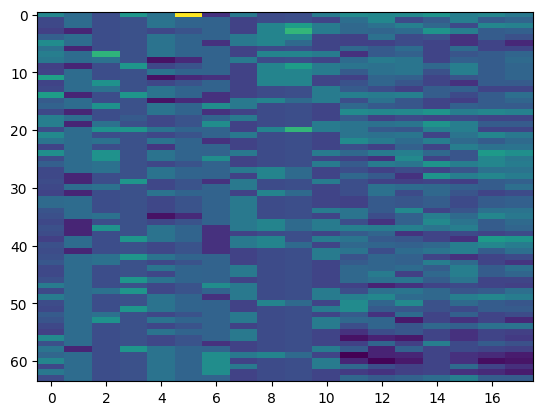

In [14]:
demo_cli_merge_data = np.concatenate((demographic_data, z_imputed_data), axis=1)
import matplotlib.pyplot as plt
plt.imshow(demo_cli_merge_data, aspect='auto')
np.save(fold_path + '/nor_demo_cli_merge_data.npy', demo_cli_merge_data)

In [25]:
combine = list(zip(demo_cli_merge_data, demo_cli_merge_data, demo_cli_merge_data))

import random
random.shuffle(combine)

a, b, c = zip(*combine)
print(a[0])
print(b[0])
print(c[0])


[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]


In [24]:


Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

In [26]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

X_train = X
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = CatBoostClassifier(verbose=0)

# 参数网格
param_grid = {
    'learning_rate': [1e-6],
    'depth': [4],
    'l2_leaf_reg': [5],
    'iterations': [100],
    'border_count': [32],


}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


ModuleNotFoundError: No module named 'catboost'

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

X_train = X
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = XGBClassifier(scale_pos_weight=61*1e5)

# 参数网格
# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [4],  # Depth of trees. Increasing this value will make the model more complex and more likely to overfit.
    'learning_rate': [0.01],  # Step size shrinkage used to prevent overfitting. Range is [0,1]
    'scale_pos_weight': [1e2],  # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'scale_pos_weight': 100.0}
Best score: 1.0


In [30]:
demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)
demographic_data = demographic_data.astype(float)
demographic_data = np.nan_to_num(demographic_data, 0)
demographic_data = zscore(demographic_data, axis=0)
print(demographic_data)

[[ 1.54893332  0.52915026 -0.60535015  2.1665957   0.81749636  6.79962494
  -1.51102763  1.03175391 -0.67419986 -0.5400228   1.13389342]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337  1.4832397   2.50951771  1.13389342]
 [-1.05259005 -1.88982237 -0.60535015 -0.42521972 -0.80064077 -0.40961596
   0.1855648  -0.96922337  1.4832397   3.52603121  1.13389342]
 [ 0.04278821  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648   1.03175391  1.4832397   1.4930042  -0.8819171 ]
 [ 1.82277789  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
  -1.51102763  1.03175391  1.4832397   0.4764907  -0.8819171 ]
 [ 0.72739963 -1.88982237 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [ 1.27508876  0.52915026  3.40248531 -0.

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Create a scorer for specificity
specificity_scorer = make_scorer(specificity_score)

X_train = X[:, -2:]
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)
models = {
    'CatBoost': CatBoostClassifier(scale_pos_weight=5, verbose=0),
    'XGBoost': XGBClassifier(scale_pos_weight=61 * 1e5),
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'Support Vector': SVC(),
    'NearestNeighbor': KNeighborsClassifier(),
    'Perceptron': Perceptron()
}


results = {}

for model_name, model in models.items():
    # Define the scorers you want to use
    scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'sensitivity': make_scorer(recall_score),
                'specificity': specificity_scorer}
    
    # Perform 5-fold cross-validation and get the results
    cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Calculate mean scores
    mean_accuracy = cv_results['test_balanced_accuracy'].mean()
    mean_sensitivity = cv_results['test_sensitivity'].mean()
    mean_specificity = cv_results['test_specificity'].mean()
    
    # Store the results
    results[model_name] = {'bAcc': mean_accuracy, 'Sensitivity': mean_sensitivity, 'Specificity': mean_specificity}
    print(f"model - {model_name} - metrics - {results[model_name]}")


model - CatBoost - metrics - {'bAcc': 0.6633333333333333, 'Sensitivity': 0.6666666666666666, 'Specificity': 0.6599999999999999}
model - XGBoost - metrics - {'bAcc': 0.6466666666666667, 'Sensitivity': 0.7333333333333333, 'Specificity': 0.5599999999999999}
model - RandomForest - metrics - {'bAcc': 0.6166666666666666, 'Sensitivity': 0.4333333333333333, 'Specificity': 0.8}
model - DecisionTree - metrics - {'bAcc': 0.5733333333333333, 'Sensitivity': 0.36666666666666664, 'Specificity': 0.78}
model - Support Vector - metrics - {'bAcc': 0.5, 'Sensitivity': 0.0, 'Specificity': 1.0}
model - NearestNeighbor - metrics - {'bAcc': 0.49000000000000005, 'Sensitivity': 0.0, 'Specificity': 0.9800000000000001}
model - Perceptron - metrics - {'bAcc': 0.48999999999999994, 'Sensitivity': 0.3, 'Specificity': 0.6799999999999999}


In [140]:
X.shape

(64, 19)

scaled by 1000000.0 Accuracy: 0.46875 Sensitivity is 0.35714285714285715 Specificity is 0.5
[0.51746528 0.43333333 0.60159722]
scaled by 1000000.0 Accuracy: 0.390625 Sensitivity is 0.21428571428571427 Specificity is 0.44
[0.51527778 0.428125   0.60243056]
scaled by 1000000.0 Accuracy: 0.453125 Sensitivity is 0.2857142857142857 Specificity is 0.5
[0.51024306 0.42135417 0.59913194]
scaled by 1000000.0 Accuracy: 0.4375 Sensitivity is 0.21428571428571427 Specificity is 0.5
[0.50923611 0.41979167 0.59868056]
scaled by 1000000.0 Accuracy: 0.390625 Sensitivity is 0.21428571428571427 Specificity is 0.44
[0.51526042 0.428125   0.60239583]
scaled by 1000000.0 Accuracy: 0.4375 Sensitivity is 0.35714285714285715 Specificity is 0.46
[0.50767361 0.4125     0.60284722]
scaled by 1000000.0 Accuracy: 0.390625 Sensitivity is 0.21428571428571427 Specificity is 0.44
[0.50414931 0.40572917 0.60256944]
scaled by 1000000.0 Accuracy: 0.453125 Sensitivity is 0.35714285714285715 Specificity is 0.48
[0.50302083 

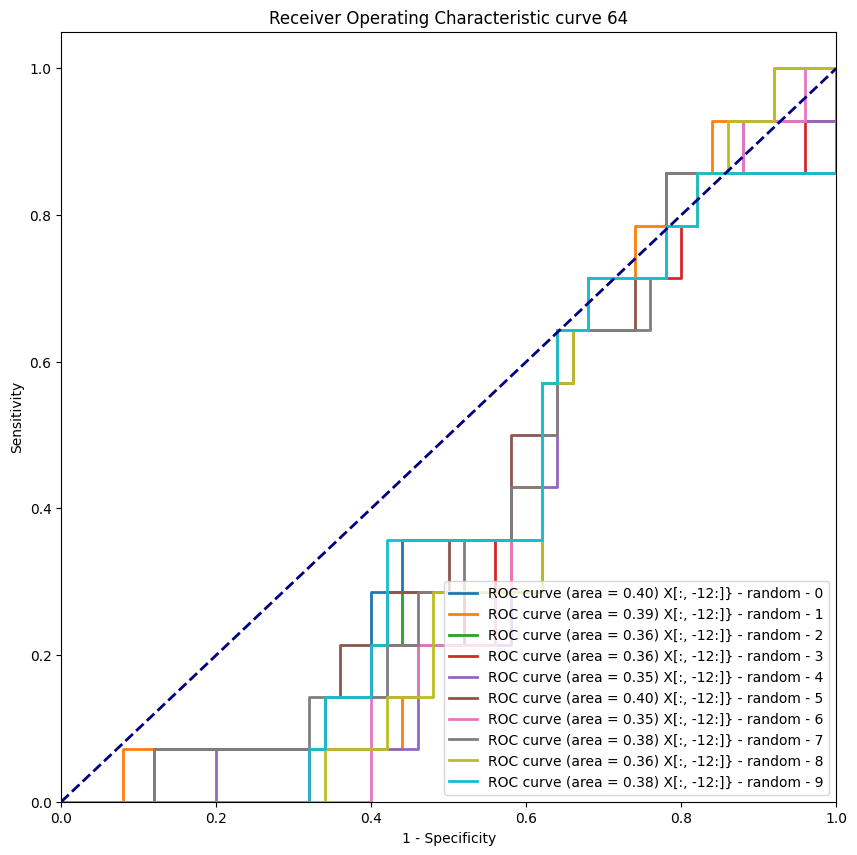

In [197]:
from sklearn.model_selection import LeaveOneOut, cross_validate, KFold, cross_val_predict
from sklearn.metrics import make_scorer, balanced_accuracy_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import numpy as np


scale = 1e6# for scale in [1e6]: # [1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]:
plt.figure(figsize=(10, 10))
feature_i = 11 # for feature_i in range(X.shape[1]):

models = {
    'XGBoost': XGBClassifier(scale_pos_weight=scale, eval_metric='logloss'),
}

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Create a scorer for specificity
specificity_scorer = make_scorer(specificity_score)

scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'sensitivity': make_scorer(recall_score),
                'specificity': specificity_scorer}
# Assuming X, Y, and a dictionary of models are already defined

# Outer loop: Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
Y = np.load(fold_path + '/label.npy', allow_pickle=True)

X_tmp = X.copy()[:, -feature_i-1:-1]
Y_tmp = Y.copy()

all_fpr_tpr = []
for shuffle_i in range(10):
    
    y_pred_all = []
    results = {}
    all_inner_fold = []
    y_pred_prob_all = []

    # Shuffle X_tmp and Y_tmp
    shuffled_indices = np.random.permutation(X_tmp.shape[1])
    X_tmp_shuffled = X_tmp[:,shuffled_indices]
    Y_tmp_shuffled = Y_tmp#[shuffled_indices]




    # for model_name, model in models.items():
    model_name = 'XGBoost'
    model = XGBClassifier(scale_pos_weight=scale, eval_metric='logloss')
    balanced_accuracy_scores = []
    sensitivity_scores = []

    for train_index, test_index in loo.split(X):
        # Splitting the dataset for this LOOCV iteration
        X_train, X_test = X_tmp_shuffled[train_index], X_tmp_shuffled[test_index]
        Y_train, Y_test = Y_tmp_shuffled[train_index], Y_tmp_shuffled[test_index]
        cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring, return_train_score=False)
    
        # Calculate mean scores
        mean_accuracy = cv_results['test_balanced_accuracy'].mean()
        mean_sensitivity = cv_results['test_sensitivity'].mean()
        mean_specificity = cv_results['test_specificity'].mean()
        
        # Store the results
        results[model_name] = {'bAcc': mean_accuracy, 'Sensitivity': mean_sensitivity, 'Specificity': mean_specificity}
        all_inner_fold.append([results[model_name]['bAcc'], results[model_name]['Sensitivity'], results[model_name]['Specificity']])
        # print('inner cv results', results[model_name])
        # Inner loop: 5-fold cross-validation for training and validating the model
        # Note: Adjustments might be needed depending on how you intend to use the results of inner CV for model selection or tuning
        
        # Train the model using the inner CV folds
        # Note: You might use cross_val_predict or another approach here for model selection or tuning
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        probabilities = model.predict_proba(X_test)
        y_pred_prob_all.append(probabilities)
        y_pred_all.append(Y_pred)



    y_pred_ind = []
    for i in range(len(y_pred_all)):
        y_pred_ind.append(y_pred_all[i][0])
    accuracy = accuracy_score(Y_tmp_shuffled, y_pred_ind)

    # Calculate sensitivity (recall)
    sensitivity = recall_score(Y_tmp_shuffled, y_pred_ind)  # This is already done in your snippet

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(Y_tmp_shuffled, y_pred_ind).ravel()
    specificity = tn / (tn + fp)
    print(f"scaled by {scale} Accuracy: {accuracy} Sensitivity is {sensitivity} Specificity is {specificity}")
    np_y_pred_prob_all = np.array([i[0] for i in y_pred_prob_all])
    fpr, tpr, _ = roc_curve(Y_tmp_shuffled, np_y_pred_prob_all[:, 1])
    all_fpr_tpr.append([fpr, tpr])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) X[:, -%d:]} - random - %d' % (roc_auc, int(feature_i)+1, shuffle_i))

    all_inner_fold = np.array(all_inner_fold)
    all_inner_fold_mean = np.mean(all_inner_fold, axis=0)
    print(all_inner_fold_mean)
# Plotting the ROC curve

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title(f'Receiver Operating Characteristic curve {i+1}')
plt.legend(loc="lower right")
plt.show()

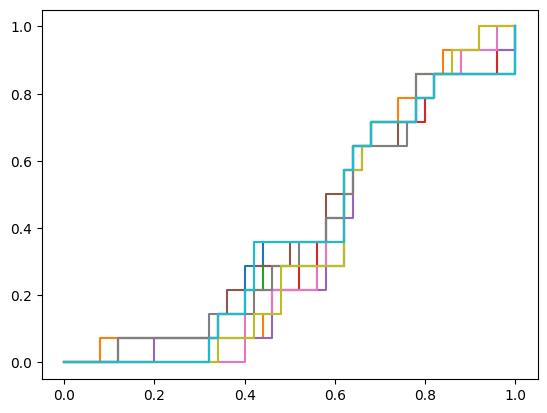

In [198]:
for i in all_fpr_tpr:
    plt.plot(i[0], i[1])

In [199]:
fprs = []
tprs = []
roc_aucs = []
for i in all_fpr_tpr:
    fprs.append(i[0])
    tprs.append(i[1])
    roc_aucs.append(auc(i[0], i[1]))

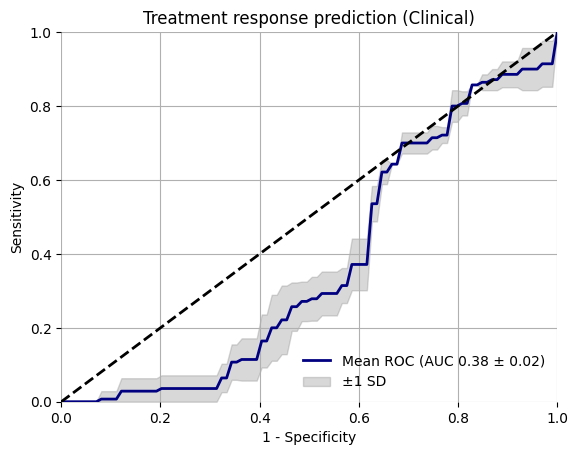

In [201]:

from scipy import interp
mean_fpr = np.linspace(0, 1, 100)

# Interpolate TPRs at these common FPR levels
mean_tpr = np.zeros_like(mean_fpr)
tpr_interpolated = []

for i in range(len(fprs)):
    tpr_interp = np.interp(mean_fpr, fprs[i], tprs[i])
    tpr_interpolated.append(tpr_interp)
    
    
# Calculate the mean TPR
tpr_interpolated = np.array(tpr_interpolated)
mean_tpr = tpr_interpolated.mean(axis=0)
std_tpr = tpr_interpolated.std(axis=0)

tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

# Compute AUC
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(roc_aucs)
# mean_fpr = np.linspace(0, 1, 100)
# mean_tpr = np.zeros_like(mean_fpr)
# mean_tpr = np.interp(mean_fpr, fpr, tpr)
# roc_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, lw=2, color='#000080', label='Mean ROC (AUC %0.2f ± %0.2f)' % (roc_auc, std_auc))
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3, label='±1 SD')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title(f'Treatment response prediction (Clinical)')
plt.legend(loc="lower right", frameon=False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()



# plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

In [1]:
import matplotlib.pyplot as plt
fusion_data[:,-1:]

last_fusion_data = fusion_data[:,-1:].copy()
pos_las = last_fusion_data[Y_train == 1]
neg_las = last_fusion_data[Y_train == 0]
plt.hist(pos_las, bins=20, alpha=0.5, label='Positive')

plt.figure()
plt.hist(neg_las, bins=20, alpha=0.5, label='Negative')

NameError: name 'fusion_data' is not defined